<a href="https://colab.research.google.com/github/davidabelin/deep_dream_variations/blob/main/double_digits_dreams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DeepDream

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Intro

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/deepdream"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/deepdream.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/deepdream.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/deepdream.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial contains a minimal implementation of DeepDream, as described in this [blog post](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) by Alexander Mordvintsev.

DeepDream is an experiment that visualizes the patterns learned by a neural network. Similar to when a child watches clouds and tries to interpret random shapes, DeepDream over-interprets and enhances the patterns it sees in an image.

It does so by forwarding an image through the network, then calculating the gradient of the image with respect to the activations of a particular layer. The image is then modified to increase these activations, enhancing the patterns seen by the network, and resulting in a dream-like image. This process was dubbed "Inceptionism" (a reference to [InceptionNet](https://arxiv.org/pdf/1409.4842.pdf), and the [movie](https://en.wikipedia.org/wiki/Inception) Inception).

Let's demonstrate how you can make a neural network "dream" and enhance the surreal patterns it sees in an image.

![Dogception](https://www.tensorflow.org/tutorials/generative/images/dogception.png)

##Set up

In [ ]:
#@title IMPORTS
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython import display
from IPython.display import clear_output
import PIL.Image

import seaborn as sbn
import random as rd
import numpy as np
import pandas as pd
import zipfile
import math
import os, signal

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, InputLayer, Input, Dropout
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adagrad
from tensorflow.keras.preprocessing import image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
####From "Classifying Handwritten Digits with Neural Networks tutorial"

mnist_dataframe = pd.read_csv(
                            "https://download.mlcc.google.com/mledu-datasets/mnist_train_small.csv",
                            sep=",",
                            header=None)

# Use just the first 10,000 records for training/validation.
N = 10000
mnist_dataframe = mnist_dataframe.head(N)

#mnist_dataframe = mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))
#mnist_dataframe

In [ ]:
#@title Define parse_labels_and_features()
def parse_labels_and_features(dataset):
    """Extracts labels and features.
    
    This is a good place to scale or transform the features if needed.
    
    Args:
        dataset: A Pandas `Dataframe`, containing the label on the first column and
        monochrome pixel values on the remaining columns, in row major order.
    Returns:
        A `tuple` `(labels, features)`:
        labels: A Pandas `Series`.
        features: A Pandas `DataFrame`.
    """
    labels = dataset[0]

    # DataFrame.loc index ranges are inclusive at both ends.
    features = dataset.loc[:,1:784]

    # Prenormed for dreamifier:
    features = (2.0/255)*features-1

    return labels, features

In [ ]:
#@title Define show_layer_output()

def show_layer_output(model, output_model, dataset):
    """
    Inputs: model, output_model is layer outputs of model, dataset=a fully loaded tf Dataset of examples and targets
    Outputs: true answers, best guesses, the corresponding prediction probabilities for each,
             and the image being predicted
    """
    ############################ its own internal version of guessing()
    ############################ always returns image
    def guessing(n=1,model=model,dataset=dataset):
        answers, guesses, pA, pG = [],[],[],[]
        for count in range(n):
            take1_ds = dataset.shuffle(10001).take(1)
            for img, ans in take1_ds:
                ans = ans.numpy()
                img = img.numpy()                  # eg. 28x56x1
            img = img.reshape((1,) + img.shape)    # eg. 1x50x50x1
            guess_set = model.predict(img).flatten()
            #guess = tf.random.categorical( guess_set, num_samples=1 ).numpy().squeeze()
            guess = np.argmax(guess_set)       
            answers += [ans]
            guesses += [guess]
            pG += [guess_set[guess]]
            pA += [guess_set[ans]]
            print("Answer",ans,"\tGuess",guess, "\tp(A)",round(pA[count],2),"\tp(G)",round(pG[count],2))
            if count%10 == 0:
                print ('Processing...',count,"...")
                display.clear_output(wait=True)
        return answers, guesses, pA, pG, img
    ############################ 

    answers, guesses, pA, pG, img = guessing()
    print("Answer:",answers[0],"\tp(Answer):",round(pA[0],3))
    print("Guess:",guesses[0],"\tp(Guess):",round(pG[0],3))
    plt.figure(figsize=(2.5,2.5))
    plt.imshow(img[0,:,:,0]) 

    layer_output_maps = output_model.predict( img )
    layer_names = [layer.name for layer in model.layers[1:]]

    for layer_name, layer_map in zip(layer_names, layer_output_maps):
    ############################ your included / excluded layers here:
        print ("layer:",layer_name,"map shape:",layer_map.shape)
        if not "dense" in layer_name and not "dropout" in layer_name and not "flatten" in layer_name:
            #if "flatten" in layer_name:
    ############################ your image shape here:
                #layer_map = layer_map.reshape(1,50,50,10)
            n_maps = layer_map.shape[-1]  # number of maps
            grid_rows = max(1, n_maps//10)
            # Map has shape (1, rows, columns, n_maps)
            rows = layer_map.shape[1]
            cols = layer_map.shape[2]
            image_grid = np.zeros((rows * grid_rows, cols * min(10,n_maps)))

            for gridrow in range(grid_rows):
                for map_n in range(min(10,n_maps)):
                        x = layer_map[0, :, :, map_n+10*gridrow]
                        #x[-1:1,-1:1] = np.mean(x)
                        #x[0:0] = np.max(x)
                        #x[0:1,0:5] = np.mean(x)
                        #[0:1,5:] = np.max(x)
                        #x *= 255.0
                        image_grid[gridrow*rows:(gridrow+1)*rows , map_n*cols:(map_n+1)*cols] = x
                        
            scale = 2.2          
            plt.figure(figsize=(scale * 10, scale * grid_rows))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(image_grid, cmap='gray')

    return answers, guesses, pA, pG, img

## Make double digits
* make double digit images with labels 0 - 99

In [ ]:
dd_targets, dd_examples = parse_labels_and_features(mnist_dataframe)

In [ ]:
#@title Define getDDs()
def getDDs(n):
    new_examples = pd.DataFrame(columns=[r for r in range(1568)])
    new_targets = []
    for i in range(n):
        left = rd.choice(dd_examples.index.values)   
        right = rd.choice(dd_examples.index.values)

        answer = dd_targets[left]*10 + dd_targets[right]
        new_targets += [answer]

        bkgrnd = np.zeros((28,56))   
        bkgrnd[:,0:28] += dd_examples.loc[left].values.reshape((28,28))
        bkgrnd[:,28:56] += dd_examples.loc[right].values.reshape((28,28))
        if i%200 == 0:
            print ("Image",i,"of",n,"\tLabel =",answer)
            display.clear_output(wait=True)
            #plt.imshow(bkgrnd)
        bkgrnd = pd.Series(bkgrnd.reshape(1568))
        new_examples = new_examples.append(bkgrnd, ignore_index=True)
    return pd.Series(new_targets), new_examples

In [ ]:
validation_targets, validation_examples = getDDs(N//5)
training_targets, training_examples = getDDs(4*N//5)

Show a random example and its corresponding label.

In [ ]:
rand_example = np.random.choice(training_examples.index)
_, ax = plt.subplots()
ax.matshow(training_examples.loc[rand_example].values.reshape(28, 56))
ax.set_title("Label: %i" % training_targets.loc[rand_example])
ax.grid(False)

##Make a model to extract from

In [ ]:
######################## Friendlier data to 'see'
x_train = training_examples.values.reshape(training_examples.shape[0],28,56)
x_test = validation_examples.values.reshape(validation_examples.shape[0],28,56)
y_train, y_test = training_targets, validation_targets

######################## Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

####################### TF Datasets for input
train_ds = tf.data.Dataset.from_tensor_slices( (x_train, y_train) )
test_ds = tf.data.Dataset.from_tensor_slices( (x_test, y_test) )

In [ ]:
########################## Extract model

input_layer = layers.Input(shape=(28,56,1))
x = layers.Conv2D(30, 7, activation='relu', padding='same')(input_layer) # 
x = layers.Conv2D(20, 5, activation='relu', padding='same')(x) 
x = layers.Conv2D(10, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(10, activation='relu')(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output_layer = layers.Dense(100, activation='softmax')(x)
####################### Build
extract_model = Model(input_layer, output_layer)

####################### Compile
extract_model.compile(loss="sparse_categorical_crossentropy",
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=Adam(lr=0.005), #0.0075
              metrics=['acc'])
    
####################### Layer-outputs model
layer_outputs = [layer.output for layer in extract_model.layers[1:]]
extract_output_model = Model(input_layer, layer_outputs)

####################### History containers
answers, guesses = [],[]
extract_model.summary()

In [ ]:
#############################
extract_history = extract_model.fit(train_ds.shuffle(N).batch(100),
                                    validation_data=test_ds.batch(20),  
                                    epochs=1,  
                                    verbose=1)

In [ ]:
answers, guesses, pA, pG, img = show_layer_output(extract_model,
                                                  extract_output_model,
                                                  test_ds)

## Choose an image to dream-ify

In [ ]:
# Download an image and read it into a NumPy array.
def sideload(image_path, max_dim=None):
  #name = url.split('/')[-1]
  #image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess_tf(img):
  img = 255*(img + 1)/2
  return tf.cast(img, tf.uint8)

def deprocess(img):
  img = 255*(img + 1)/2
  return img

# Display an image
def show(img):
    #try:
    #    display.display(PIL.Image.fromarray(np.array(img)))
    #except (KeyError, TypeError):
    #    print ("Failed to display PIL image. Using imshow:")
    plt.imshow(img[:,:,0])

# Downsizing the image makes it easier to work with.
#original_img = sideload('/content/treemx0.png', max_dim=500)
original_img = img.reshape((28,56,1))
original_img = deprocess(original_img)
show(original_img)
#plt.imshow(original_img[:,:,0])

## Prepare the feature extraction model

Download and prepare a pre-trained image classification model. You will use [InceptionV3](https://keras.io/applications/#inceptionv3) which is similar to the model originally used in DeepDream. Note that any [pre-trained model](https://keras.io/applications/#models-for-image-classification-with-weights-trained-on-imagenet) will work, although you will have to adjust the layer names below if you change this.

In [ ]:
#base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
base_model = extract_model
base_model.summary()

The idea in DeepDream is to choose a layer (or layers) and maximize the "loss" in a way that the image increasingly "excites" the layers. The complexity of the features incorporated depends on layers chosen by you, i.e, lower layers produce strokes or simple patterns, while deeper layers give sophisticated features in images, or even whole objects.

The InceptionV3 architecture is quite large (for a graph of the model architecture see TensorFlow's [research repo](https://github.com/tensorflow/models/tree/master/research/inception)). For DeepDream, the layers of  interest are those where the convolutions are concatenated. There are 11 of these layers in InceptionV3, named 'mixed0' though 'mixed10'. Using different layers will result in different dream-like images. Deeper layers respond to higher-level features (such as eyes and faces), while earlier layers respond to simpler features (such as edges, shapes, and textures). Feel free to experiment with the layers selected below, but keep in mind that deeper layers (those with a higher index) will take longer to train on since the gradient computation is deeper.

In [ ]:
base_model.predict(np.expand_dims(original_img,axis=0))

In [ ]:
for lay in base_model.layers:
    print(lay.name, lay.output_shape)

In [ ]:
# Maximize the activations of these layers
def get_outputs(names):
    layers = [base_model.get_layer(name).output for name in names]
    return names, layers
names, layers = get_outputs(['conv2d_2'])

# Create the feature extraction model
def get_dream_model(inputs,outputs):
    return tf.keras.Model(inputs=base_model.input, outputs=layers)
dream_model = get_dream_model(base_model.input, layers)

## Calculate loss

The loss is the sum of the activations in the chosen layers. The loss is normalized at each layer so the contribution from larger layers does not outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you will maximize this loss via gradient ascent.

In [ ]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
        layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

  return  tf.reduce_sum(losses)

## Gradient ascent

Once you have calculated the loss for the chosen layers, all that is left is to calculate the gradients with respect to the image, and add them to the original image. 

Adding the gradients to the image enhances the patterns seen by the network. At each step, you will have created an image that increasingly excites the activations of certain layers in the network.

The method that does this, below, is wrapped in a `tf.function` for performance. It uses an `input_signature` to ensure that the function is not retraced for different image sizes or `steps`/`step_size` values. See the [Concrete functions guide](../../guide/concrete_function.ipynb) for details.

In [ ]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  #@tf.function(
  #    input_signature=(
  #      tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
  #      tf.TensorSpec(shape=[], dtype=tf.int32),
  #      tf.TensorSpec(shape=[], dtype=tf.float32),)
  #  )
  def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img`
                # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.model)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 
            
            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [ ]:
deepdream = DeepDream(dream_model)

## Main Loop

In [ ]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess_tf(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

## Experimentation

Answer: 67 	p(Answer): 0.742
Guess: 67 	p(Guess): 0.742
layer: conv2d map shape: (1, 28, 56, 30)
layer: conv2d_1 map shape: (1, 28, 56, 20)
layer: conv2d_2 map shape: (1, 28, 56, 10)
layer: max_pooling2d map shape: (1, 14, 28, 10)
layer: flatten map shape: (1, 3920)
layer: dense map shape: (1, 10)
layer: dense_1 map shape: (1, 500)
layer: dropout map shape: (1, 500)
layer: dense_2 map shape: (1, 100)


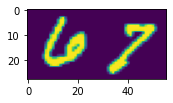

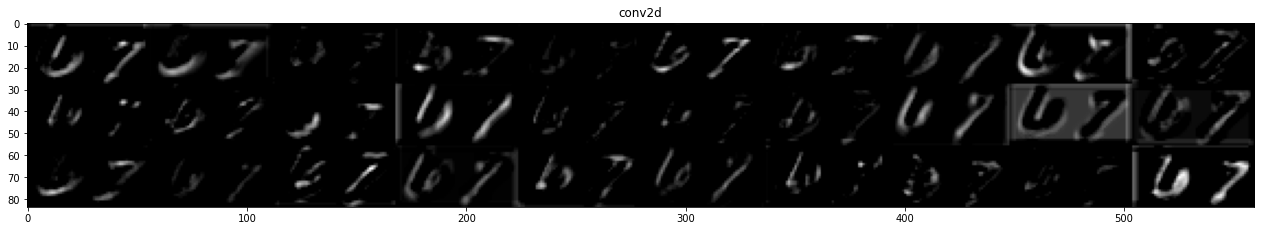

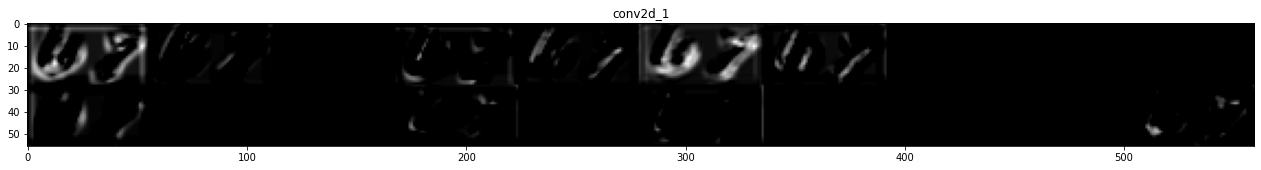

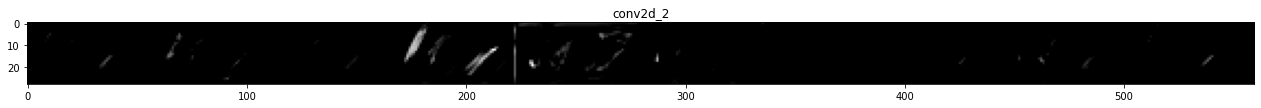

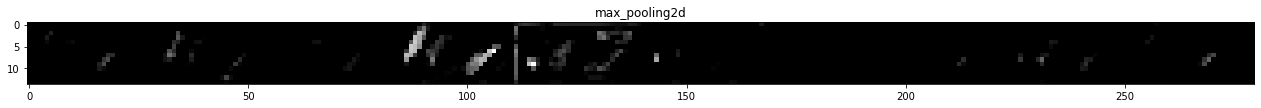

In [ ]:
answers, guesses, pA, pG, img = show_layer_output(extract_model,
                                                  extract_output_model,
                                                  test_ds)

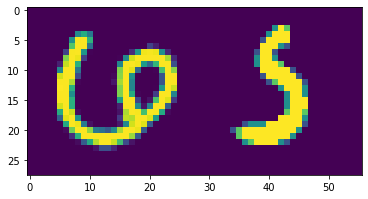

In [ ]:
######################### GET IMAGE, NO NOISE
r = rd.choice(list(range(x_test.shape[0])))
xti = x_test[r]
xti = xti[:,:,0]
xti = 255*(xti +1)/2
dream_img = np.expand_dims(xti,axis=-1)
plt.imshow(dream_img[:,:,0])

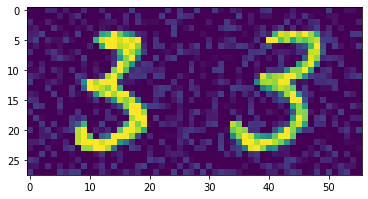

In [ ]:
#### GET IMAGE WITH NOISE
r = rd.choice(list(range(x_test.shape[0])))
xti = x_test[r]
xti = xti[:,:,0]
xti = 255*(xti +1)/2
for y in range(xti.shape[1]):
    for x in range(xti.shape[0]):
        xti[x,y] += rd.randrange(-50,50)
xti = np.clip(xti,0,255)
dream_img = np.expand_dims(xti, axis=-1)
plt.imshow(xti)

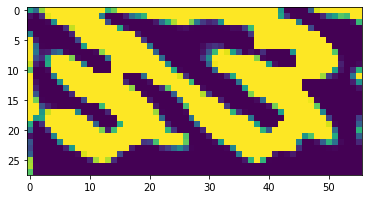

In [ ]:
dream_img = run_deep_dream_simple(img=dream_img, 
                                  steps=200, step_size=0.015)